In [1]:
!pip3 install torch


In [0]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.manual_seed(1)

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5])
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) 
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False) 

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, stride=1)
    self.conv2 = nn.Conv2d(20, 50, 5, stride=1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
#   since we are using crossentropy loss, it already has softmax in it, so raw
#   output should be final without any activation function   
    return x
  
  
    

In [7]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
epochs = 15
history=[]
val_history=[]
for e in range(epochs):
  current_loss = 0.0
  running_correct = 0.0
  validation_loss = 0.0
  validation_acc = 0.0
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
#     inputs = inputs.view(inputs.shape[0], -1)   this is required is passing 1 dimensional input
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    
    current_loss += loss.item()
    running_correct += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        
#         val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_output = model(val_inputs)
        val_loss = criterion(val_output, val_labels)
        
        _, val_preds = torch.max(val_output, 1)
        validation_loss += val_loss.item()
        validation_acc += torch.sum(val_preds == val_labels.data)
           
      epoch_loss = current_loss/(len(training_loader))
      epoch_acc = running_correct.float()/len(training_loader)
      validation_loss = validation_loss/(len(validation_loader))
      validation_acc = validation_acc.float()/len(validation_loader)
      history.append(epoch_loss)
      print('training loss: {:.4f}, training accuracy: {:.4f}, validation loss: {:.4f}, validation accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item(), validation_loss, validation_acc.item()))
    
    

training loss: 0.3472, training accuracy: 88.8133, validation loss: 0.1327, validation accuracy: 96.3200
training loss: 0.1373, training accuracy: 96.2167, validation loss: 0.1182, validation accuracy: 96.6600
training loss: 0.1339, training accuracy: 96.4383, validation loss: 0.1546, validation accuracy: 95.9900
training loss: 0.1369, training accuracy: 96.4383, validation loss: 0.1314, validation accuracy: 96.8200
training loss: 0.1366, training accuracy: 96.5917, validation loss: 0.1562, validation accuracy: 96.3700
training loss: 0.1336, training accuracy: 96.6083, validation loss: 0.1576, validation accuracy: 96.2100
training loss: 0.1281, training accuracy: 96.8033, validation loss: 0.1273, validation accuracy: 96.9200
training loss: 0.1415, training accuracy: 96.5400, validation loss: 0.1517, validation accuracy: 96.5500
training loss: 0.1347, training accuracy: 96.6933, validation loss: 0.1411, validation accuracy: 96.5800
training loss: 0.1229, training accuracy: 96.9733, vali

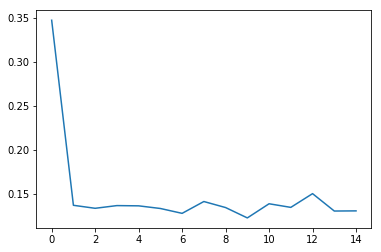

In [10]:
plt.plot(history, label="training loss")
plt.plot(val_history, label="validation loss")
plt.legend()

In [0]:
# we need a smaller LR for smoother curve. 
# Look into validation in the video